In [1]:
from gsnn.models.GSNN import GSNN 

import pandas as pd 
import torch 
import numpy as np 
from matplotlib import pyplot as plt 

from torch.utils.data import Dataset, DataLoader 

import torch_geometric as pyg 

from DeepTraj.models.DeepTraj import dose_transform
from DeepTraj.models.MLP import MLP

#from torchdiffeq import odeint_adjoint as odeint 
from torchdiffeq import odeint 
import time 

from sklearn.metrics import r2_score

from lincs_gsnn.data.TrajDataset import TrajDataset
from lincs_gsnn.data.DXDTDataset import DXDTDataset
from lincs_gsnn.models.ODEFunc import ODEFunc
from lincs_gsnn.utils.GaussianNLL import GaussianNLL

import copy 

%load_ext autoreload
%autoreload 2


/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
gene_names = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/gene_names.csv')['gene_names'].values.astype(str)
meta = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/pred_meta.csv')
dxdt_meta = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/dxdt_meta.csv')
meta.head()

,pert_id,cell_iname,dose,time_min,time_max,n_time_pts,file_name
0,BRD-K49328571,HME1,0.000,0,24.0,100,pred__BRD-K49328571_HME1_0.0.pt
1,BRD-K49328571,HME1,0.001,0,24.0,100,pred__BRD-K49328571_HME1_0.001.pt
2,BRD-K49328571,HME1,0.010,0,24.0,100,pred__BRD-K49328571_HME1_0.01.pt
3,BRD-K49328571,HME1,0.100,0,24.0,100,pred__BRD-K49328571_HME1_0.1.pt
4,BRD-K49328571,HME1,1.000,0,24.0,100,pred__BRD-K49328571_HME1_1.0.pt


In [3]:
drug_names = meta.pert_id.unique() 
cell_names = meta.cell_iname.unique()
dose_values = meta.dose.unique() 
min_time = meta.time_min.values[0]
max_time = meta.time_max.values[0] 
n_time = meta.n_time_pts.values[0]

print(f"Number of drugs: {len(drug_names)}")
print(f"Number of cells: {len(cell_names)}")
print(f"Number of doses: {len(dose_values)}")
print(f"Time range: {min_time} to {max_time} with {n_time} time points")
print(f"Number of features: {len(gene_names)}")

t = torch.linspace(min_time, max_time, n_time)


Number of drugs: 8
Number of cells: 11
Number of doses: 6
Time range: 0 to 24.0 with 100 time points
Number of features: 978


In [4]:
data = torch.load('/home/teddy/local/lincs-gsnn/workflow/runs/default/bionetwork/bionetwork.pt', weights_only=False)

In [5]:
print('# edges:')
print(f'\tinput->function: {data['edge_index_dict'][('input','to', 'function')].shape[1]}')
print(f'\tfunction->function: {data['edge_index_dict'][('function','to', 'function')].shape[1]}')
print(f'\tfunction->output: {data['edge_index_dict'][('function','to', 'output')].shape[1]}')

# edges:
	input->function: 17170
	function->function: 22982
	function->output: 972


In [6]:
model = torch.load('../workflow/runs/default/pretrain/pretrained_model.pt', weights_only=False)
dxdt_scale = torch.load('../workflow/runs/default/pretrain/dxdt_scale.pt', weights_only=False).item()
model.eval()

GSNN(
  (ResBlocks): ModuleList(
    (0-6): 7 x ResBlock(
      (lin_in): SparseLinear(
        (conv): Conv()
      )
      (lin_out): SparseLinear(
        (conv): Conv()
      )
      (norm): BatchNorm1d(4320, eps=0.001, momentum=0.1, affine=False, track_running_stats=True)
      (nonlin): ELU(alpha=1.0)
    )
  )
)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
full_dataset = TrajDataset(meta, 
                      input_names=data.node_names_dict['input'], 
                      obs_dir='/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/obs')

full_dataloader = DataLoader(full_dataset, batch_size=8, shuffle=False)

In [9]:
func = ODEFunc(model.eval(), 
               input_names=data.node_names_dict['input'],
               scale=dxdt_scale).to(device)

R2 score: 0.91


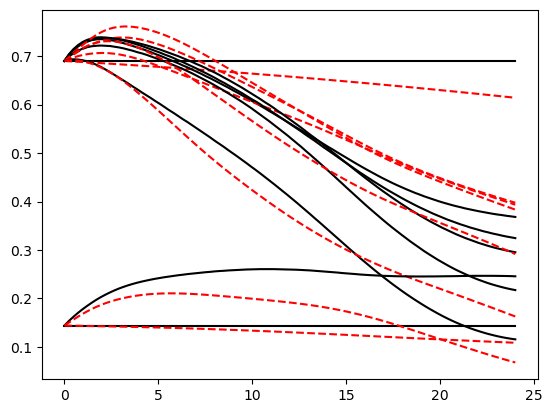

In [10]:

xt_mu, xt_sigma, X = next(iter(full_dataloader))

xt_mu = xt_mu.to(device)
xt_sigma = xt_sigma.to(device)
X = X.to(device)

t = torch.linspace(min_time, max_time, n_time, device=device)

with torch.no_grad():
    out = odeint(func=func, y0=X, t=t, method='dopri5').transpose(0, 1)  # (n_time, B, n_input_nodes) 

xt_hat = out[:, :, func.gene_ixs]  # (n_time, B, n_genes)


delta_ = xt_mu.detach().cpu().numpy() - xt_mu[:, [0], :].detach().cpu().numpy()
delta_hat_ = xt_hat.detach().cpu().numpy() - xt_mu[:, [0], :].detach().cpu().numpy()
r2 = r2_score(delta_.ravel(), delta_hat_.ravel(), multioutput='uniform_average')
print(f'R2 score: {r2:.2f}')

## plot 

gene_ix = 33

plt.figure() 
for i in range(xt_mu.shape[0]):
    plt.plot(t.cpu().numpy(), xt_mu.detach().cpu().numpy()[i, :, gene_ix], 'k')
    plt.plot(t.cpu().numpy(), xt_hat.detach().cpu().numpy()[i, :, gene_ix], 'r--')

plt.show() 

# Fine tune with neural ODE style training 

In [23]:
traj_dataset = TrajDataset(meta, 
                      input_names=data.node_names_dict['input'], 
                      obs_dir='/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/obs') 

traj_dataloader = DataLoader(traj_dataset, batch_size=8, shuffle=True, num_workers=20, persistent_workers=True)


In [24]:
func = ODEFunc(copy.deepcopy(model).eval(),
               input_names=data.node_names_dict['input'],
               scale=dataset._scale).to(device) 

optim = torch.optim.AdamW(func.parameters(), lr=1e-6, weight_decay=0)

crit = torch.nn.MSELoss(reduction='mean')

In [26]:
torch.cuda.empty_cache()

In [25]:
for epoch in range(100): 

    losses = 0
    r2s = 0
    tic = time.time()
    for i, (xt_mu, xt_sigma, X) in enumerate(traj_dataloader):
        torch.cuda.empty_cache()  # clear GPU memory
        optim.zero_grad()
        xt_mu = xt_mu.to(device)
        xt_sigma = xt_sigma.to(device)
        X = X.to(device)

        #tt = torch.linspace(0, horizon, xt_mu.shape[1], device=device)  # time points for the trajectory

        out = odeint(func=func, y0=X, t=t, method='dopri5').transpose(0, 1)  # (n_time, B, n_input_nodes) 

        xt_hat = out[:, :, func.gene_ixs]

        #loss = crit(xt_hat, xt_mu, xt_sigma) 
        loss = crit(xt_hat, xt_mu)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optim.step()
        losses += loss.item()
        delta_ = xt_mu.detach().cpu().numpy() - xt_mu[:, [0], :].detach().cpu().numpy()
        delta_hat_ = xt_hat.detach().cpu().numpy() - xt_mu[:, [0], :].detach().cpu().numpy()
        r2 = r2_score(delta_.ravel(), delta_hat_.ravel(), multioutput='uniform_average')
        r2s += r2
        print(f'[batch {i}/{len(traj_dataloader)} -> loss: {loss.item():.3f}, r2: {r2:.2f}]', end='\r')

    print(f'--> epoch {epoch+1} -> loss: {losses/len(traj_dataloader):.4E} | r2: {r2s/len(traj_dataloader):2f} | time/epoch: {time.time() - tic:.2f}s')
        

KeyboardInterrupt: 

R2 score: 1.00


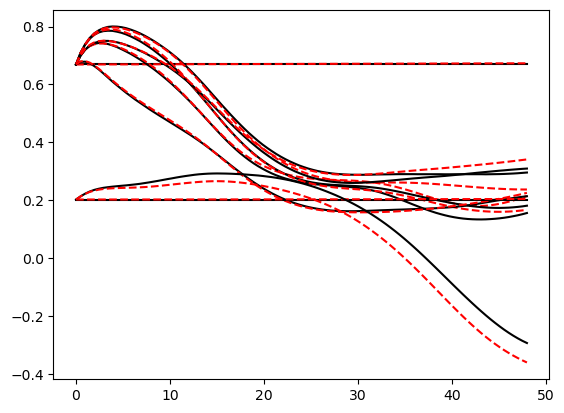

In [ ]:

xt_mu, xt_sigma, X = next(iter(full_dataloader))

xt_mu = xt_mu.to(device)
xt_sigma = xt_sigma.to(device)
X = X.to(device)

t = torch.linspace(min_time, max_time, n_time, device=device)

with torch.no_grad():
    out = odeint(func=func, y0=X, t=t, method='dopri5').transpose(0, 1)  # (n_time, B, n_input_nodes) 

xt_hat = out[:, :, func.gene_ixs]  # (n_time, B, n_genes)

delta_ = xt_mu.detach().cpu().numpy() - xt_mu[:, [0], :].detach().cpu().numpy()
delta_hat_ = xt_hat.detach().cpu().numpy() - xt_mu[:, [0], :].detach().cpu().numpy()
r2 = r2_score(delta_.ravel(), delta_hat_.ravel(), multioutput='uniform_average')
print(f'R2 score: {r2:.2f}')

## plot 

gene_ix = 33

plt.figure() 
for i in range(xt_mu.shape[0]):
    plt.plot(t.cpu().numpy(), xt_mu.detach().cpu().numpy()[i, :, gene_ix], 'k')
    plt.plot(t.cpu().numpy(), xt_hat.detach().cpu().numpy()[i, :, gene_ix], 'r--')

plt.show() 